In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import os
#thanks @keskarnitish

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K40m (CNMeM is disabled, cuDNN 5105)


# Generate names
* Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train NN instead.
* Dataset contains ~8k human names from different cultures[in latin transcript]
* Objective (toy problem): learn a generative model over names.

In [2]:
start_token = " "

with open("names") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token+name for name in names]
    

In [3]:
print ('n samples = ',len(names))
for x in names[::1000]:
    print (x)

n samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


# Text processing

In [4]:
#all unique characters go here
tokens = set(''.join(names))

tokens = list(tokens)
print ('n_tokens = ',len(tokens))

n_tokens =  55


In [5]:
#!token_to_id = <dictionary of symbol -> its identifier (index in tokens list)>
token_to_id = {t: i for i,t in enumerate(tokens) }

#!id_to_token = < dictionary of symbol identifier -> symbol itself>
id_to_token = dict(enumerate(tokens))

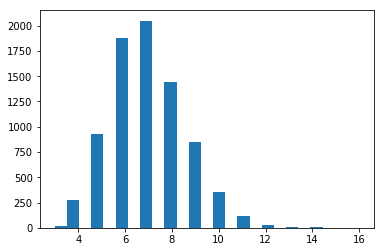

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(list(map(len,names)),bins=25);

In [7]:
# truncate names longer than MAX_LEN characters. 
MAX_LEN = 10

#you will likely need to change this for any dataset different from "names"

### Cast everything from symbols into identifiers

In [8]:
names_ix = list(map(lambda name: list(map(token_to_id.get,name)),names))


#crop long names and pad short ones
for i in range(len(names_ix)):
    names_ix[i] = names_ix[i][:MAX_LEN] #crop too long
    
    if len(names_ix[i]) < MAX_LEN:
        names_ix[i] += [token_to_id[" "]]*(MAX_LEN - len(names_ix[i])) #pad too short
        
assert len(set(map(len,names_ix)))==1

names_ix = np.array(names_ix)

# Input variables

In [9]:
input_sequence = T.matrix('token sequencea','int32')
target_values = T.matrix('actual next token','int32')


# Build NN

You will be building a model that takes token sequence and predicts next token


* iput sequence
* one-hot / embedding
* recurrent layer(s)
* otput layer(s) that predict output probabilities


In [10]:
from lasagne.layers import InputLayer,DenseLayer,EmbeddingLayer
from lasagne.layers import RecurrentLayer,LSTMLayer,GRULayer,CustomRecurrentLayer

In [11]:

l_in = lasagne.layers.InputLayer(shape=(None, None),input_var=input_sequence)

#!<Your neural network>
l_emb = EmbeddingLayer(l_in, len(tokens), 8)

l_rnn = GRULayer(l_emb, 32)

#flatten batch and time to be compatible with feedforward layers (will un-flatten later)
l_rnn_flat = lasagne.layers.reshape(l_rnn, (-1,l_rnn.output_shape[-1]))

l_out = lasagne.layers.DenseLayer(l_rnn_flat, len(tokens), nonlinearity=lasagne.nonlinearities.softmax)

In [12]:
# Model weights
weights = lasagne.layers.get_all_params(l_out,trainable=True)
print (weights)

[W, W_in_to_updategate, W_hid_to_updategate, b_updategate, W_in_to_resetgate, W_hid_to_resetgate, b_resetgate, W_in_to_hidden_update, W_hid_to_hidden_update, b_hidden_update, W, b]


In [13]:
network_output = lasagne.layers.get_output(l_out)
#If you use dropout do not forget to create deterministic version for evaluation

In [14]:
predicted_probabilities_flat = network_output
correct_answers_flat = target_values.ravel()


loss = lasagne.objectives.categorical_crossentropy(predicted_probabilities_flat, correct_answers_flat).mean()

updates = lasagne.updates.adam(loss, weights)

# Compiling it

In [15]:

#training
train = theano.function([input_sequence, target_values], loss, updates=updates, allow_input_downcast=True)

#computing loss without training
compute_cost = theano.function([input_sequence, target_values], loss, allow_input_downcast=True)


# generation

Simple: 
* get initial context(seed), 
* predict next token probabilities,
* sample next token, 
* add it to the context
* repeat from step 2

You'll get a more detailed info on how it works in the homework section.

In [16]:
#compile the function that computes probabilities for next token given previous text.

#reshape back into original shape
next_word_probas = network_output.reshape((input_sequence.shape[0],input_sequence.shape[1],len(tokens)))
#predictions for next tokens (after sequence end)
last_word_probas = next_word_probas[:,-1]
probs = theano.function([input_sequence],last_word_probas,allow_input_downcast=True)


In [17]:

def generate_sample(seed_phrase=None,N=MAX_LEN,t=1,n_snippets=1):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
        
    parameters:
        sample_fun - max_ or proportional_sample_fun or whatever else you implemented
        
        The phrase is set using the variable seed_phrase

        The optional input "N" is used to set the number of characters of text to predict.     
    '''
    if seed_phrase is None:
        seed_phrase=start_token
    if len(seed_phrase) > MAX_LEN:
        seed_phrase = seed_phrase[-MAX_LEN:]
    assert type(seed_phrase) is str

    snippets = []
    for _ in range(n_snippets):
        sample_ix = []
        x = list(map(lambda c: token_to_id.get(c,0), seed_phrase))
        x = np.array([x])

        for i in range(N):
            # Pick the character that got assigned the highest probability
            p = probs(x).ravel()
            p = p**t / np.sum(p**t)
            ix = np.random.choice(np.arange(len(tokens)),p=p)
            sample_ix.append(ix)

            x = np.hstack((x[-MAX_LEN+1:],[[ix]]))

        random_snippet = seed_phrase + ''.join(id_to_token[ix] for ix in sample_ix)    
        snippets.append(random_snippet)
        
    print("----\n %s \n----" % '; '.join(snippets))


# Model training

Here you can tweak parameters or insert your generation function


__Once something word-like starts generating, try increasing seq_length__



In [18]:
def sample_batch(data, batch_size):
    
    rows = data[np.random.randint(0,len(data),size=batch_size)]
    
    return rows[:,:-1],rows[:,1:]

In [19]:
from IPython.display import clear_output

In [20]:
print("Training ...")


#total N iterations
n_epochs=50

# how many minibatches are there in the epoch 
batches_per_epoch = 500

#how many training sequences are processed in a single function call
batch_size=20


for epoch in range(n_epochs):

    print( "Generated names")
    generate_sample(n_snippets=10)

    avg_cost = 0;
    
    for _ in range(batches_per_epoch):
        
        x,y = sample_batch(names_ix,batch_size)
        avg_cost += train(x, y)
        
    print("Epoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))
    if epoch % 10 == 0:
        clear_output(True)


Generated names
----
  Con       ;  Siderde   ;  Luletenne ;  Jalolied  ;  Bancy     ;  Emmie     ;  Grenn     ;  Rothan    ;  Pinetta   ;  Caristi    
----
Epoch 41 average loss = 1.5632817339897156
Generated names
----
  Nar       ;  Kiamar    ;  Bionabret ;  Cleag     ;  Belbem    ;  Jerre     ;  Owine     ;  Manda     ;  Jeznie    ;  Elli       
----
Epoch 42 average loss = 1.549780816555023
Generated names
----
  Isellah   ;  Jonnie    ;  Sibelee   ;  Marah     ;  Dadmy     ;  Tsiy      ;  Allite    ;  Marchgabel;  Caraba    ;  Silv       
----
Epoch 43 average loss = 1.5553604907989502
Generated names
----
  Mudinue   ;  Jocert    ;  Althert   ;  Elisit    ;  Sticord   ;  Dody      ;  Jimira    ;  Lis       ;  Elaja     ;  Ladesho    
----
Epoch 44 average loss = 1.5484518339633941
Generated names
----
  Merley    ;  Cadier    ;  Jonetta   ;  Aloire    ;  Law       ;  Oryth     ;  Mor       ;  Janeline  ;  Rapheldert;  Deomendos  
----
Epoch 45 average loss = 1.5530347924232484
G

In [21]:
generate_sample(n_snippets=100)

----
  Dadola    ;  Eis       ;  Ala-Jorol ;  Freddy    ;  Horrie    ;  Harsie    ;  Lones     ;  Idrera    ;  Velina    ;  Mavi      ;  Gerin     ;  Flid      ;  Barille   ;  Bellaim   ;  Cop       ;  Angwas    ;  Rechelen  ;  Milesta   ;  Corth     ;  Kar       ;  Cari      ;  Roril     ;  Huliquia  ;  Vogy      ;  Kisti     ;  Bid       ;  Rosolia   ;  Noladi    ;  Ryzoten   ;  Ches      ;  Lean      ;  Merricka  ;  Banti     ;  Elivia    ;  Hysti     ;  Syb       ;  Span      ;  Cersia    ;  Tavervi   ;  Groeter   ;  Sherlee   ;  Kridtan   ;  Ferray    ;  Lunette   ;  Helone    ;  Mairre    ;  Roda      ;  Clais     ;  Dannita   ;  Anille    ;  Lina      ;  Elgelince ;  Shelmi    ;  Erwi      ;  Charly    ;  Xina      ;  Tryn      ;  Jomin     ;  Nivalah   ;  Kaedie    ;  Catham    ;  Rachickell;  Tilwerd   ;  Sheena    ;  Givianne  ;  Melissine ;  Margeal   ;  Ephell    ;  Grances   ;  Maren-Jann;  Cheana    ;  Hullyn    ;  Katus     ;  Terra     ;  Jocos     ;  Potlaby   ;  Hilor

In [22]:
generate_sample(seed_phrase=" Miron",n_snippets=10)

----
  Mironi         ;  Mironina       ;  Miron          ;  Mironah        ;  Mirone         ;  Mironie        ;  Mirona         ;  Mironey        ;  Mirona         ;  Mirono          
----


## Homework part 1 - generate questions (4 pts)

* Apply recurrent neural networks to generate human-readable questions.
* The dataset origins from https://www.kaggle.com/c/quora-question-pairs - a recent kaggle challenge.
* The code below shows how to read the dataset
* Please download the __train dataset__ from [here](https://www.kaggle.com/c/quora-question-pairs/data)
* Avoid using test dataset as it contains artificially generated data.
* Alternatively, pick any similar dataset you like.

### [bonus] Word-level model (4+ points)

Learn to generate questions on _word_ level, generating one word per RNN iteration.

Kudos for 
* pre-training embedding layer with word2vec or similar
* using more compute-efficient softmax functions (hierarchical or sampled softmax)
* anything creative :)

In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import os
#thanks @keskarnitish

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K40m (CNMeM is disabled, cuDNN 5105)


In [2]:
import pandas as pd
df = pd.read_csv("./train.csv")
df = pd.concat([df.question1,df.question2])

questions = list(set(df))
questions = filter(lambda x: type(x) is str, questions)
start_token,end_token = " ",";"
questions = [start_token+name.replace(";",",")+end_token for name in questions]

print('n samples = ',len(questions))
for x in questions[::100000]:
    print (x)

n samples =  537361
 Does the band Tool have any love songs?;
 Should I go for executive MBA or consider switching job?;
 Where can I find a happy ending in Brooklyn?;
 Who is responsible for partition of India in 1947?;
 How did you meet your significant other?;
 Can you spy on a cellphone without having to download software to the target phone?;


In [3]:
questions = [question.encode('utf-8') for question in questions]

In [14]:
questions = [list(map(chr, question)) for question in questions]

# Text Processing

In [17]:
tokens = set()
for question in questions:
    tokens.update(question)

tokens = list(tokens)
print ('n_tokens = ',len(tokens))

n_tokens =  198


In [32]:
#!token_to_id = <dictionary of symbol -> its identifier (index in tokens list)>
token_to_id = {t: i for i,t in enumerate(tokens) }

#!id_to_token = < dictionary of symbol identifier -> symbol itself>
id_to_token = {i: t for i,t in enumerate(tokens) }

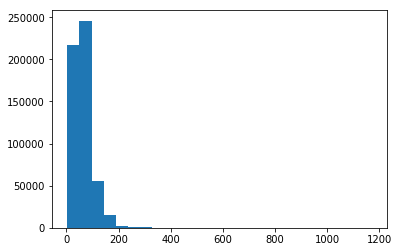

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(list(map(len,questions)),bins=25);

In [37]:
# truncate names longer than MAX_LEN characters. 
MAX_LEN = 100

#you will likely need to change this for any dataset different from "names"

### Cast everything from symbols into identifiers

In [38]:
questions_ix = list(map(lambda question: list(map(token_to_id.get, question)),questions))


#crop long names and pad short ones
for i in range(len(questions_ix)):
    questions_ix[i] = questions_ix[i][:MAX_LEN] #crop too long
    
    if len(questions_ix[i]) < MAX_LEN:
        questions_ix[i] += [token_to_id[" "]]*(MAX_LEN - len(questions_ix[i])) #pad too short
        
assert len(set(map(len,questions_ix))) == 1

questions_ix = np.array(questions_ix)

# Input variables

In [39]:
input_sequence = T.matrix('token sequence','int32')
target_values = T.matrix('actual next token','int32')

# Build NN

In [40]:
from lasagne.layers import InputLayer,DenseLayer,EmbeddingLayer
from lasagne.layers import RecurrentLayer,LSTMLayer,GRULayer,CustomRecurrentLayer

In [41]:
l_in = lasagne.layers.InputLayer(shape=(None, None),input_var=input_sequence)
l_emb = EmbeddingLayer(l_in, len(tokens), 8)
l_rnn = GRULayer(l_emb, 32)
l_rnn_flat = lasagne.layers.reshape(l_rnn, (-1,l_rnn.output_shape[-1]))
l_out = lasagne.layers.DenseLayer(l_rnn_flat, len(tokens), nonlinearity=lasagne.nonlinearities.softmax)

In [42]:
# Model weights
weights = lasagne.layers.get_all_params(l_out,trainable=True)
print (weights)

[W, W_in_to_updategate, W_hid_to_updategate, b_updategate, W_in_to_resetgate, W_hid_to_resetgate, b_resetgate, W_in_to_hidden_update, W_hid_to_hidden_update, b_hidden_update, W, b]


In [43]:
network_output = lasagne.layers.get_output(l_out)
#If you use dropout do not forget to create deterministic version for evaluation

In [44]:
predicted_probabilities_flat = network_output
correct_answers_flat = target_values.ravel()

loss = lasagne.objectives.categorical_crossentropy(predicted_probabilities_flat, correct_answers_flat).mean()

updates = lasagne.updates.adam(loss, weights)

# Compiling it

In [45]:
#training
train = theano.function([input_sequence, target_values], loss, updates=updates, allow_input_downcast=True)

#computing loss without training
compute_cost = theano.function([input_sequence, target_values], loss, allow_input_downcast=True)

# Generation

In [46]:
next_word_probas = network_output.reshape((input_sequence.shape[0],input_sequence.shape[1],len(tokens)))
last_word_probas = next_word_probas[:,-1]
probs = theano.function([input_sequence],last_word_probas,allow_input_downcast=True)

In [47]:
def generate_sample(seed_phrase=None,N=MAX_LEN,t=1,n_snippets=1):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
        
    parameters:
        sample_fun - max_ or proportional_sample_fun or whatever else you implemented
        
        The phrase is set using the variable seed_phrase

        The optional input "N" is used to set the number of characters of text to predict.     
    '''
    if seed_phrase is None:
        seed_phrase=start_token
    if len(seed_phrase) > MAX_LEN:
        seed_phrase = seed_phrase[-MAX_LEN:]
    assert type(seed_phrase) is str

    snippets = []
    for _ in range(n_snippets):
        sample_ix = []
        x = list(map(lambda c: token_to_id.get(c,0), seed_phrase))
        x = np.array([x])

        for i in range(N):
            # Pick the character that got assigned the highest probability
            p = probs(x).ravel()
            p = p**t / np.sum(p**t)
            ix = np.random.choice(np.arange(len(tokens)),p=p)
            sample_ix.append(ix)

            x = np.hstack((x[-MAX_LEN+1:],[[ix]]))

        random_snippet = seed_phrase + ''.join(id_to_token[ix] for ix in sample_ix)    
        snippets.append(random_snippet)
        
    print("----\n %s \n----" % '; '.join(snippets))

# Model training

In [48]:
def sample_batch(data, batch_size):
    
    rows = data[np.random.randint(0,len(data),size=batch_size)]
    
    return rows[:,:-1],rows[:,1:]

In [49]:
from IPython.display import clear_output

In [ ]:
print("Training ...")


#total N iterations
n_epochs=10

# how many minibatches are there in the epoch 
batches_per_epoch = 500

#how many training sequences are processed in a single function call
batch_size=10


for epoch in range(n_epochs):

    print( "Generated questions")
    generate_sample(n_snippets=2)

    avg_cost = 0;
    
    for _ in range(batches_per_epoch):
        
        x,y = sample_batch(questions_ix,batch_size)
        avg_cost += train(x, y)
        
    print("Epoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))
    if epoch % 5 == 0:
        clear_output(True)

In [55]:
generate_sample(n_snippets=2, t=2)
generate_sample(n_snippets=2, t=4)

----
 Is it possible to get a job in In ? ;                            
 What are the best ways to improve the English skills ? ;                          
----
----
 What is the best way to get a job in the US ? ;                      
 What is the best way to get a job in a foreign country ? ;                    
----


При более высокой температуре вопросы получаются отличными